In [41]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

In [42]:
# Image dimensions for reference
IMG_HEIGHT = 400
IMG_WIDTH = 640

# Fixed bounding box dimensions
RECT_WIDTH = 450
RECT_HEIGHT = 200

In [43]:
def roundness(contour):
    area = cv.contourArea(contour)
    perimeter = cv.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return 4 * np.pi * area / (perimeter ** 2)

def find_largest_component(thresh):
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresh)
    max_area = 0
    best_bbox = None

    for label in range(1, num_labels):  # skip background
        area = stats[label, cv.CC_STAT_AREA]
        if area > max_area:
            max_area = area
            best_bbox = stats[label].tolist()

    return best_bbox

def find_largest_circular_component(thresh):
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresh)
    max_area = 0
    pupil_center = None
    best_roundness = 0
    best_bbox = None

    for label in range(1, num_labels):  # skip background
        component_mask = (labels == label).astype(np.uint8)
        contours, _ = cv.findContours(component_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        contour = contours[0]
        r = roundness(contour)
        area = cv.contourArea(contour)

        if r > 0.6 and area > max_area:
            max_area = area
            best_roundness = r
            pupil_center = tuple(map(int, centroids[label]))
            best_bbox = stats[label].tolist()  # convert to list for unpacking

    return pupil_center, best_bbox

def show_image(title, image):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_histogram(image, title):
    plt.figure()
    plt.hist(image.ravel(), bins=256, range=(0, 256))
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

**Load and resize**

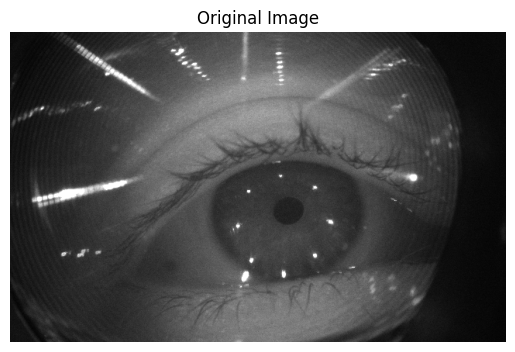

In [44]:
img_path = '/Users/omaraguilarjr/Downloads/0.png'
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv.INTER_AREA)
show_image('Original Image', img)

**Edge Masking**

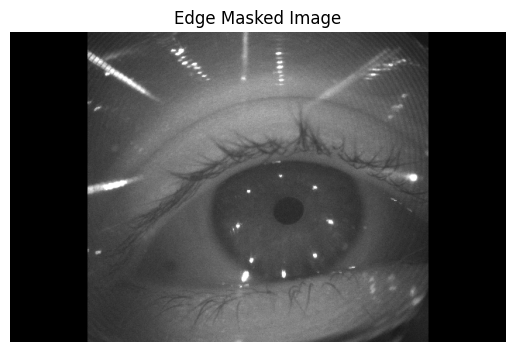

In [45]:
mask = np.ones_like(img, dtype=np.uint8)
mask[:, :100] = 0
mask[:, -100:] = 0
masked_img = cv.bitwise_and(img, img, mask=mask)
show_image('Edge Masked Image', masked_img)

**Histogram Equalization**

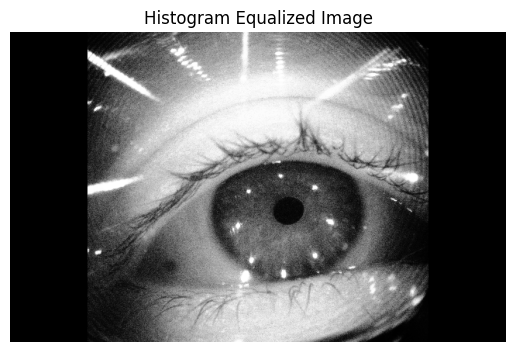

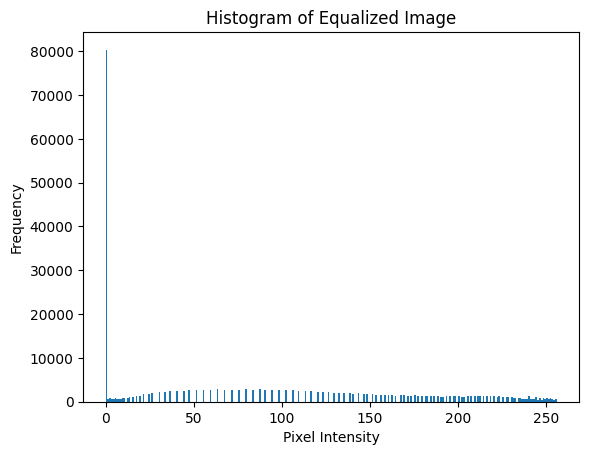

In [46]:
equalized = cv.equalizeHist(masked_img)
show_image('Histogram Equalized Image', equalized)
show_histogram(equalized, 'Histogram of Equalized Image')

**Gaussian Blur**

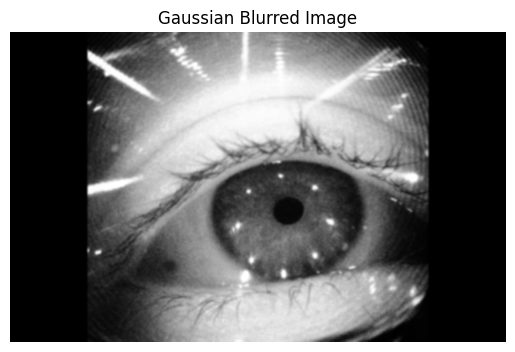

In [47]:
blurred = cv.GaussianBlur(equalized, (5, 5), 0)
show_image('Gaussian Blurred Image', blurred)

**Top-Hat Transform**

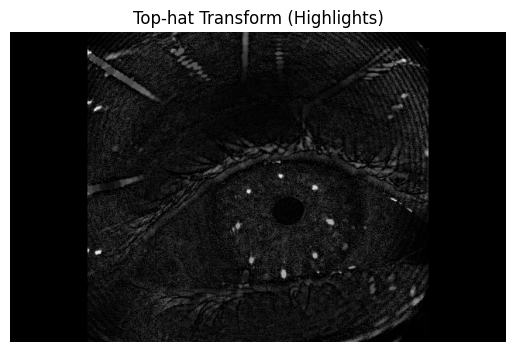

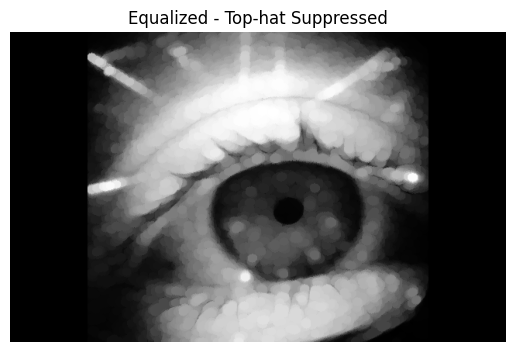

In [48]:
kernel_tophat = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
top_hat = cv.morphologyEx(equalized, cv.MORPH_TOPHAT, kernel_tophat)
show_image('Top-hat Transform (Highlights)', top_hat)
equalized_tophat = cv.subtract(equalized, top_hat)
show_image('Equalized - Top-hat Suppressed', equalized_tophat)

**CLAHE**

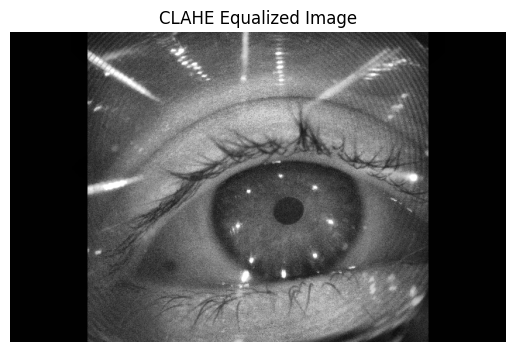

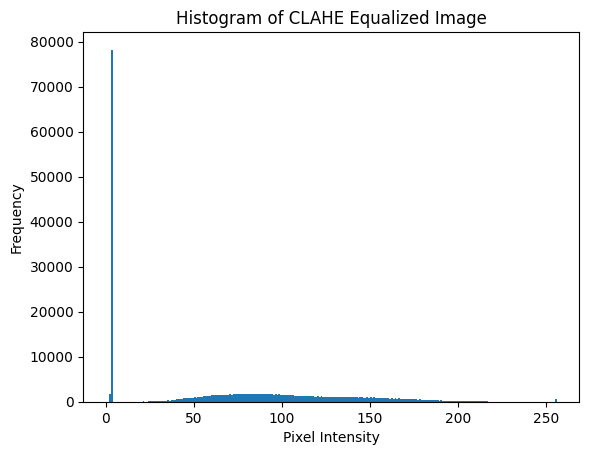

In [49]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_equalized = clahe.apply(masked_img)
show_image('CLAHE Equalized Image', clahe_equalized)
show_histogram(clahe_equalized, 'Histogram of CLAHE Equalized Image')

**Otsu's Thresholding**

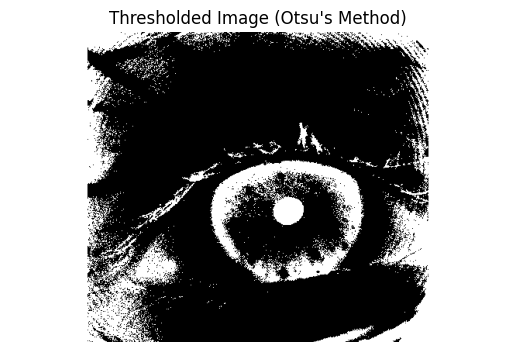

In [50]:
_, thresh_otsu = cv.threshold(clahe_equalized, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
show_image("Thresholded Image (Otsu's Method)", thresh_otsu)

**Morphological Cleaning**

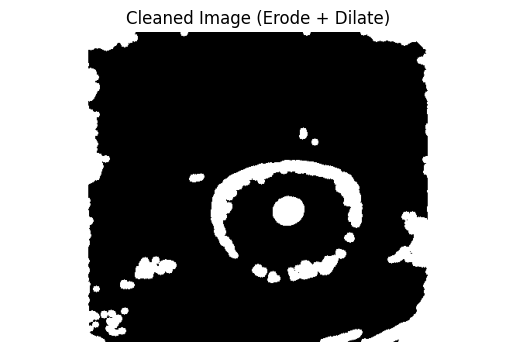

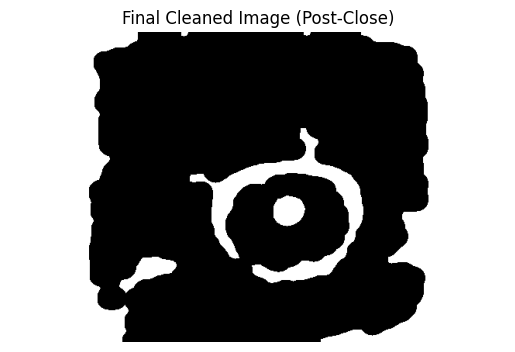

In [51]:
# Use erosion to disconnect the central blob, then dilate to restore shape
kernel_erode = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
eroded = cv.erode(thresh_otsu, kernel_erode, iterations=1)
kernel_dilate = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9, 9))
dilated = cv.dilate(eroded, kernel_dilate, iterations=1)
show_image('Cleaned Image (Erode + Dilate)', dilated)

# Optional: extra closing to smooth out jagged edges
kernel_close = cv.getStructuringElement(cv.MORPH_ELLIPSE, (30, 30))
final_cleaned = cv.morphologyEx(dilated, cv.MORPH_CLOSE, kernel_close)
show_image('Final Cleaned Image (Post-Close)', final_cleaned)

**Connected Component Analysis**

In [52]:
pupil_center, bbox = find_largest_circular_component(final_cleaned)
bbox_nc = find_largest_component(final_cleaned)

**Draw Bounding Box**

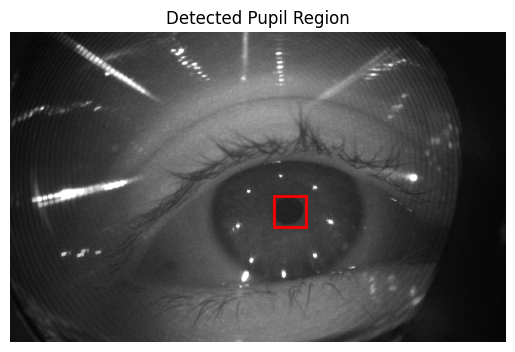

In [53]:
x, y, w, h = bbox[:4]

plt.imshow(img, cmap='gray')
rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)
plt.title('Detected Pupil Region')
plt.axis('off')
plt.show()

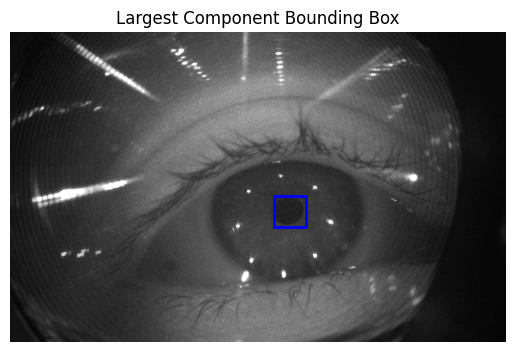

In [54]:
x, y, w, h = bbox[:4]

plt.imshow(img, cmap='gray')
rect = plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)
plt.title('Largest Component Bounding Box')
plt.axis('off')
plt.show()